# Proyecto VRP

## Estudiantes

### Librerías

In [ ]:
import pandas as pd
import numpy as np
import random
import math

from functools import cmp_to_key

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Limpieza de datos

In [ ]:
url = '/content/drive/Shareddrives/Bioinspirados/Reto/Data/RC201.xlsx'
df = pd.read_excel(url)
df.head()

,Cust. No,XCOORD,YCOORD,DEMAND,READY_TIME,DUE_DATE,SERVICE_TIME
0,1.0,40.0,50.0,0.0,0.0,960.0,0.0
1,2.0,25.0,85.0,20.0,673.0,793.0,10.0
2,3.0,22.0,75.0,30.0,152.0,272.0,10.0
3,4.0,22.0,85.0,10.0,471.0,591.0,10.0
4,5.0,20.0,80.0,40.0,644.0,764.0,10.0


In [ ]:
print(df.isna().sum())

Cust. No        0
XCOORD          0
YCOORD          0
DEMAND          0
READY_TIME      0
DUE_DATE        0
SERVICE_TIME    0
dtype: int64


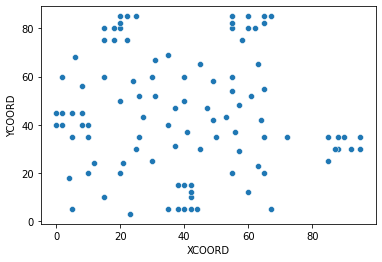

In [ ]:
sns.scatterplot( x= df['XCOORD'],y = df['YCOORD'])

In [ ]:
df.describe()

,Cust. No,XCOORD,YCOORD,DEMAND,READY_TIME,DUE_DATE,SERVICE_TIME
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,51.000000,40.089109,44.495050,17.069307,367.504950,495.821782,9.900990
std,29.300171,25.153170,24.365395,9.526025,231.613541,233.359996,0.995037
min,1.000000,0.000000,3.000000,0.000000,0.000000,131.000000,0.000000
25%,26.000000,20.000000,29.000000,10.000000,175.000000,311.000000,10.000000
50%,51.000000,40.000000,42.000000,16.000000,349.000000,472.000000,10.000000
75%,76.000000,58.000000,60.000000,20.000000,557.000000,682.000000,10.000000
max,101.000000,95.000000,85.000000,40.000000,822.000000,960.000000,10.000000


In [ ]:
minx = 0
miny = 3

maxx = 95
maxy = 85

depot_pos = ((maxx - minx)/2, (maxy - miny)/2)

In [ ]:
depot_pos

(47.5, 41.0)

In [ ]:
df = df.append({'Cust. No': 0, 'XCOORD': depot_pos[0], 'YCOORD': depot_pos[1], 'DEMAND': 0,'READY_TIME': -1, 'DUE_DATE': -1, 'SERVICE_TIME': -1}, ignore_index = True)

In [ ]:
value = (df['XCOORD'] == 47.5) & (df['YCOORD'] == 41.0) 
df['color']= np.where( value==True , "#9b59b6", "#3498db")

In [ ]:
df

,Cust. No,XCOORD,YCOORD,DEMAND,READY_TIME,DUE_DATE,SERVICE_TIME,color
0,1.0,40.0,50.0,0.0,0.0,960.0,0.0,#3498db
1,2.0,25.0,85.0,20.0,673.0,793.0,10.0,#3498db
2,3.0,22.0,75.0,30.0,152.0,272.0,10.0,#3498db
3,4.0,22.0,85.0,10.0,471.0,591.0,10.0,#3498db
4,5.0,20.0,80.0,40.0,644.0,764.0,10.0,#3498db
...,...,...,...,...,...,...,...,...
97,98.0,4.0,18.0,35.0,547.0,667.0,10.0,#3498db
98,99.0,26.0,52.0,9.0,172.0,292.0,10.0,#3498db
99,100.0,26.0,35.0,15.0,308.0,428.0,10.0,#3498db
100,101.0,31.0,67.0,3.0,810.0,930.0,10.0,#3498db


In [ ]:
df2 = pd.DataFrame({'Cust.No': [1.0, 2.0, 3.0], 'XCOORD': [40, 25, 22], 'YCOORD': [50, 85, 75]})

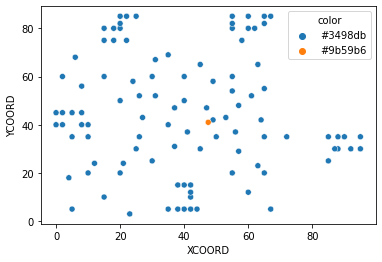

In [ ]:
sns.scatterplot( x= df['XCOORD'],y = df['YCOORD'], hue = df['color'])

In [ ]:
df_dist =  df[['XCOORD', 'YCOORD']].copy()
df_dist
from scipy.spatial import distance_matrix

matrix = pd.DataFrame(distance_matrix(df_dist.values, df_dist.values), index=df.index, columns=df.index)

In [ ]:
fleet = pd.DataFrame({
    'Vehicle': [0, 1, 2, 3, 4],
    'Capacity': [200, 300, 500, 1000, 100]})

In [ ]:
fleet

,Vehicle,Capacity
0,0,200
1,1,300
2,2,500
3,3,1000
4,4,100


In [ ]:
class Simulation:
  
  def __init__(self, n_individuals, n_iterations, population):
    self.n_individuals = n_individuals
    self.n_iterations = n_iterations
    self.population = population

 
  def run(self):
    self.population.initialize(self.n_individuals)

    for i in range(self.n_iterations):
      self.population.selection()
      self.population.crossover()
      self.population.mutation()
    
    tmp = self.population.get_best()
    self.population.plot_solution(tmp)
    

In [ ]:
class PopulationVRP:

  def __init__(self, points, vehicles, distance_matrix, mutation_ratio):
    self.points = points
    self.n_points = points.shape[0]

    self.vehicles = vehicles
    self.n_vehicles = vehicles.shape[0]
    self.distance_matrix = distance_matrix
    self.mutation_ratio = mutation_ratio

    self.objectives = [ self.objective_function_1, self.objective_function_2 ]

  def initialize(self, n_individuals):
    self.n_individuals = n_individuals
    self.population = []
    for i in range(self.n_individuals):
      self.population.append(self.generate_chromosome())

    self.childs = []
    for i in range(self.n_individuals):
      self.childs.append(self.generate_chromosome())

    return self.population

  def selection(self):
    candidates = self.population + self.childs
    candidates = sorted(candidates, key = cmp_to_key(self.compare))
    
    # Get the pareto Fronts
    F = self.get_pareto_fronts(candidates)
    x = []
    y = []
    for i in range(len(self.population)):
       x.append(self.objective_function_1(self.population[i]))
       y.append(self.objective_function_2(self.population[i]))
    #print('Frente de Pareto')
    #plt.scatter(x, y)
    #plt.show()

    # Obtain the new population with the first Paretos
    new_population = []
    minimum = min(len(F)-1, len(self.population))
    for i in range(minimum):
      new_population += F[i]

    # Missing size is the missing elements that we have to fill in the new population
    missing_size = len(self.population) - len(new_population)
    
    for i in range(missing_size):
      new_population.append(F[-1][i])

    self.population = new_population

  def crossover(self):
    offspring = []

    for i in range(0,len(self.population),2):

      child1 = []
      child2 = []

      chromosome1 = self.population[i].copy()
      chromosome2 = self.population[i+1].copy()

      chromosome1 = sorted(chromosome1)
      chromosome2 = sorted(chromosome2)

      for j in range(len(self.population[i])):
        k = np.random.random()

        if k > 0.5:
          child1.append(chromosome2[j])
          child2.append(chromosome1[j])
        else:
          child1.append(chromosome1[j])
          child2.append(chromosome2[j])

      offspring.append(child1)
      offspring.append(child2)

    self.childs = offspring

  def mutation(self):
    
    for i in range(len(self.population)):
      tmp = np.random.random()
      if tmp < self.mutation_ratio:
        for j in range(len(self.population[i])):
          tmp = np.random.random()

          if tmp < self.mutation_ratio:
            self.population[i][j] = int(self.population[i][j]) + np.random.random()

  def get_pareto_fronts(self, candidates):
    p_fs = []
    n = len(self.population)
    cont = 0
    tmp_population = candidates
    while cont < n:
      tmp_population, front = self.pareto_front(tmp_population)
      cont += len(front)
      p_fs.append(front)

    return p_fs

  def pareto_front(self, population):
    remove = np.zeros(len(population))
    f = []

    for i in range(len(population)):
      domina = True 
      for j in range(len(population)):
        if i != j:
          if (self.dominates(population[i], population[j]) == False and
              self.dominates(population[j], population[i]) == True):
            domina = False

      if domina == True:
        f.append(population[i])
        remove[i] = 1

    new_population = []
    for i in range(len(population)):
      if remove[i] == 0:
        new_population.append(population[i])

    return new_population, f

  def dominates(self, chromosome_a, chromosome_b):
    """
      Returns -1 if the chromosome A dominates the chromosome B, 1 if A dominates
      B and 0 in the case all fitness functions of all objectives have the same
      value. In this case we want to minimize both objective, thus, inequality
      is lower than
    """
    # print('Inside Dominates')
    a_no_worse_b = 0
    a_strictly_better_b = 0

    for i in range(len(self.objectives)):
      # If A is greater than B in at least one objective, means that it does not
      # dominate B. 
      value1 = self.objectives[i](chromosome_a)
      value2 = self.objectives[i](chromosome_b)

      if value1 <= value2:
        a_no_worse_b += 1
        a_strictly_better_b += 1
      elif value1 == value2:
        a_no_worse_b += 1
      else:
        return False

    return a_no_worse_b == len(self.objectives) and a_strictly_better_b >=1

  def compare(self, chromosome_a, chromosome_b):
    if self.objective_function_2(chromosome_a) < self.objective_function_2(chromosome_b):
      return -1
    
    if self.objective_function_2(chromosome_a) == self.objective_function_2(chromosome_b):
      return 0

    return 1

  def objective_function_1(self, chromosome):
    int_list = []
    for element in chromosome:
      x = math.modf(element)
      int_list.append(x[1])

      num_value = len(set(int_list))

    return num_value

  def objective_function_2(self, chromosome):
    path = self.generate_path(chromosome)

    return self.cost_dist(path)

  def cost_dist(self, subpath):
    costo = []
    for i in range(0,len(subpath)):
      tmp_costo = 0
      for j in range(0, len(subpath[i])):

        index1 = subpath[i][j][1]
        if subpath[i][j][1] != subpath[i][-1][1]:
          index2 = subpath[i][j+1][1]
        else:
          index2 = index1
        tmp_costo += self.distance_matrix[index1][index2]

      costo.append(tmp_costo)
    return max(costo)


  def generate_chromosome(self):
    chromosome = []
    max_vehicles = np.random.randint(1, self.n_vehicles+1)
    j = 0
    for i in range(self.n_points):
      city = np.random.random()
      vehicle = j%max_vehicles
      chromosome.append(vehicle + city)
      j+=1

    return chromosome


  def generate_path(self, chromosome):
    # Divide the paths into paths with same vehicle
    subpaths = [ [(i, 29)] for i in range(self.n_vehicles) ]
    
    for i in range(self.n_vehicles):
      subpaths[i].append((i + .9999999999, 29))

    for i in range(len(chromosome)):
      subpaths[int(chromosome[i])].append((chromosome[i], i))

    # Sort the subpaths
    for i in range(self.n_vehicles):
      subpaths[i].sort()

    return subpaths

  def get_best(self):
    F = self.pareto_front(self.population + self.childs)[1]

    for i in range(len(F)):
      print(F[i])
      subpath = self.generate_path(F[i])
      print('Distancia')
      print(self.objective_function_2(F[i]))
      self.plot_solution(subpath)

    return subpath

  def plot_solution(self, subpath):

    i = 0
    print(subpath)
    for path in subpath:
      points_x = []
      points_y = []

      for j in range(len(path)):
        points_x.append(self.points['XCOORD'].iloc[path[j][1]])
        points_y.append(self.points['YCOORD'].iloc[path[j][1]])
      
      plt.plot(points_x, points_y)
      sns.scatterplot(x = points_x, y = points_y)

      i+=1

    plt.show()

In [ ]:
population_vrp = PopulationVRP(
    points = df[:30],
    vehicles = fleet,
    distance_matrix = matrix,
    mutation_ratio = 0.99
)

In [ ]:
sim = Simulation(
    n_individuals = 10,
    n_iterations = 20,
    population = population_vrp
)

[0.05250067991184548, 0.3516543854652716, 0.20391946567291508, 0.06851047475916405, 0.48595368064980626, 0.598305808162805, 0.15438206024682088, 0.0782692294838272, 0.6197903312948213, 1.8170508014411233, 1.7812601711925997, 1.2098674130482294, 1.9121903371852507, 1.584942872703615, 1.2866477498526914, 1.1735165430919192, 1.6283685895675113, 1.9283479156485113, 2.3865362878165657, 2.5783044171276455, 2.8782668309054866, 2.329188644554972, 2.670898581833301, 2.5213529259614194, 2.0265215210309546, 3.8347433176791377, 3.5779965332001726, 3.2806968731519923, 3.151224249327484, 4.035163062279788]
Distancia
175.61061347936356
[[(0, 29), (0.05250067991184548, 0), (0.06851047475916405, 3), (0.0782692294838272, 7), (0.15438206024682088, 6), (0.20391946567291508, 2), (0.3516543854652716, 1), (0.48595368064980626, 4), (0.598305808162805, 5), (0.6197903312948213, 8), (0.9999999999, 29)], [(1, 29), (1.1735165430919192, 15), (1.2098674130482294, 11), (1.2866477498526914, 14), (1.584942872703615, 13

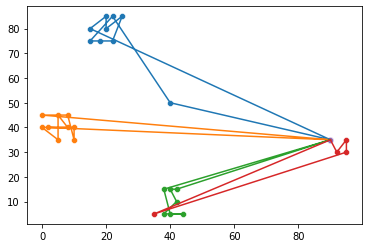

[0.04070090812459237, 0.11072477849237694, 0.11762272184894929, 0.063902195625407, 0.12962593256408272, 0.27276465950424533, 0.23703076270746604, 0.2532667719980113, 0.36158188772247757, 0.2927810867377164, 0.31076965938537227, 0.3199818873752005, 0.35074185487564813, 0.3938457570740076, 0.5322714811181773, 0.5401468253220357, 0.5678000752961996, 0.6482580578166257, 0.6744485944397183, 0.6789639306126983, 0.7116566492230695, 0.6987480214159487, 0.722320006038326, 0.730145346150279, 0.8069818238886329, 0.775671613267149, 0.9353267945158079, 0.8560469647029083, 0.9161054903773009, 0.9393027747126264]
Distancia
427.7402813470659
[[(0, 29), (0.04070090812459237, 0), (0.063902195625407, 3), (0.11072477849237694, 1), (0.11762272184894929, 2), (0.12962593256408272, 4), (0.23703076270746604, 6), (0.2532667719980113, 7), (0.27276465950424533, 5), (0.2927810867377164, 9), (0.31076965938537227, 10), (0.3199818873752005, 11), (0.35074185487564813, 12), (0.36158188772247757, 8), (0.3938457570740076

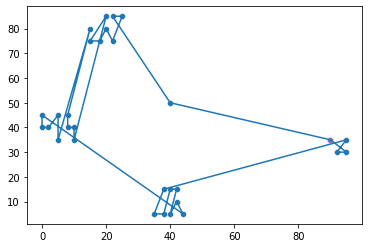

[0.034928632151580596, 0.028109134828880222, 0.12152326147429726, 0.260620898404169, 0.6898337493016434, 0.6976069870431688, 0.8745096781321486, 0.7923440537762718, 0.9834809586440043, 1.0082437270969673, 1.1574603612390568, 1.2553116380928775, 1.2408599529415443, 1.2573477215011146, 1.3324445457837917, 1.4931789243120503, 1.6927077638573826, 1.8862476910145443, 2.0730299980202354, 2.317900580569527, 2.558242423566335, 2.8386689633201114, 2.791132128088268, 2.8270129846340097, 2.9000705725061513, 3.268729738027001, 3.2974279985621453, 3.437223236031014, 3.663784757740984, 3.66944601105555]
Distancia
196.7454441429765
[[(0, 29), (0.028109134828880222, 1), (0.034928632151580596, 0), (0.12152326147429726, 2), (0.260620898404169, 3), (0.6898337493016434, 4), (0.6976069870431688, 5), (0.7923440537762718, 7), (0.8745096781321486, 6), (0.9834809586440043, 8), (0.9999999999, 29)], [(1, 29), (1.0082437270969673, 9), (1.1574603612390568, 10), (1.2408599529415443, 12), (1.2553116380928775, 11), (

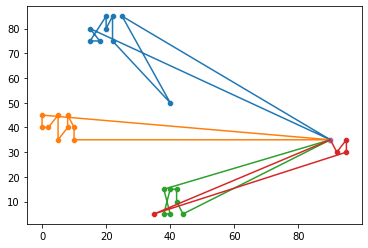

[[(0, 29), (0.028109134828880222, 1), (0.034928632151580596, 0), (0.12152326147429726, 2), (0.260620898404169, 3), (0.6898337493016434, 4), (0.6976069870431688, 5), (0.7923440537762718, 7), (0.8745096781321486, 6), (0.9834809586440043, 8), (0.9999999999, 29)], [(1, 29), (1.0082437270969673, 9), (1.1574603612390568, 10), (1.2408599529415443, 12), (1.2553116380928775, 11), (1.2573477215011146, 13), (1.3324445457837917, 14), (1.4931789243120503, 15), (1.6927077638573826, 16), (1.8862476910145443, 17), (1.9999999999, 29)], [(2, 29), (2.0730299980202354, 18), (2.317900580569527, 19), (2.558242423566335, 20), (2.791132128088268, 22), (2.8270129846340097, 23), (2.8386689633201114, 21), (2.9000705725061513, 24), (2.9999999999, 29)], [(3, 29), (3.268729738027001, 25), (3.2974279985621453, 26), (3.437223236031014, 27), (3.663784757740984, 28), (3.66944601105555, 29), (3.9999999999, 29)], [(4, 29), (4.9999999999, 29)]]


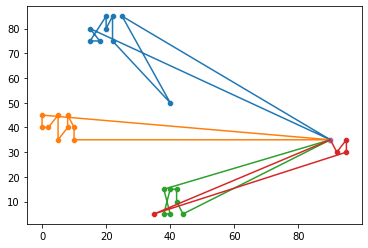

In [ ]:
sim.run()